# Text classification with an RNN


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


## 텍스트 분류 (Text classification)

단어, 문장 또는 지문 전체를 이용하여 카테고리 별로 구분하는 것을 의미

* 감성 분석  
  - 문장의 감성을 분석
  - 영화 리뷰를 보고 긍정적인 리뷰인지 부정적인 리뷰인지 분석
* 카테고리 분류
  - 문장을 카테고리 별로 분류하는 것
  - 스팸메일 분류, 블로그의 글에 대한 범주를 분류

### 영화리뷰 분석
* 인터넷 영화 데이터베이스(Internet Movie Database)에서 수집한 50,000개의 영화 리뷰 텍스트를 담은 IMDB 데이터셋을 사용  
* 25,000개 리뷰는 학습용으로, 25,000개는 테스트용으로 구분
* 학습 세트와 테스트 세트의 클래스 긍정적인 리뷰와 부정적인 리뷰의 개수가 동일 
 

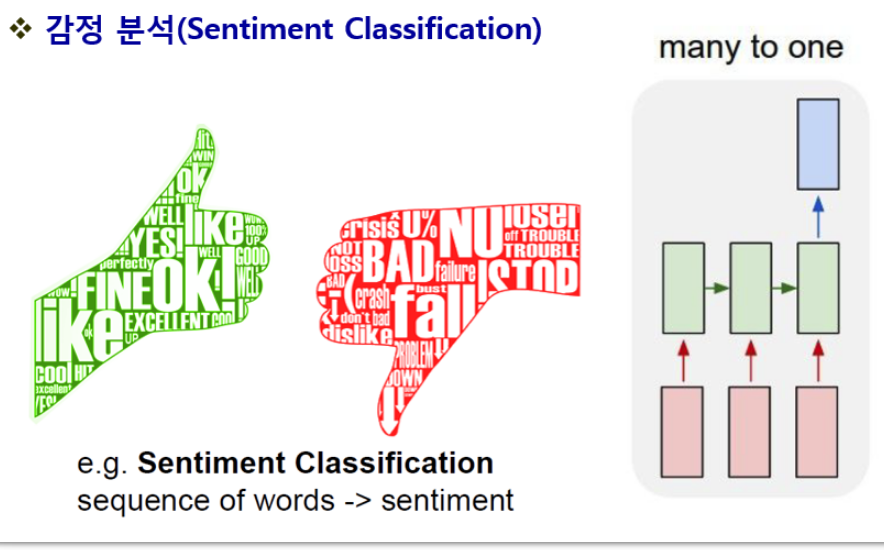

## 자연어처리에서의 문장 표현

문장을 토큰(단어 등)으로 나누어 처리

encoding : 토큰을 하나의 코드(정수)로 변환  
decoding : 코드를 단어로 변환  

embedding : 단어의 유사성을 포함시켜 벡터로 변환  
word embedding : 하나의 단어를 실수벡터로 표현  

      문장 : "i have a dream" 
      토큰 : i, have, a, dream
      인코딩 :  0,1, 2, 3, 4
      워드임베딩 : (0,2,0.3), (0.3,0.4), (0.4,0.3) , (0.5,0.6)


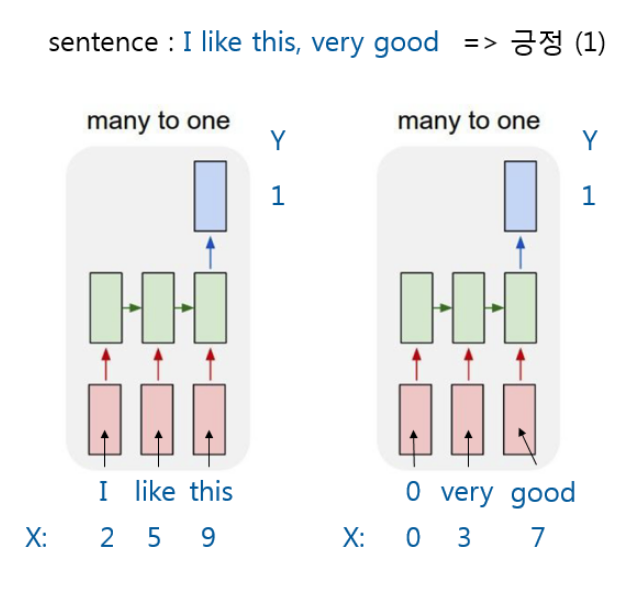

## Setup

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## DataSet

* IMDB large movie review dataset 

영화리뷰 문장,  긍정1, 부정 0으로 라벨링

subwords8k : 리뷰 문장을 단어로 분리하여 subwords8k (8185개 단어집)로  코드화한 시퀀스 데이터


In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [ ]:
#tfds.features.text.SubwordTextEncoder

encoder = info.features['text'].encoder
print('Vocabulary size: {}'.format(encoder.vocab_size))
print('Vocabulary subwords: {}'.format(encoder.subwordsvocab_size))


In [ ]:
##info 의 'text' encoder 얻어서 decoding

for x, y in train_dataset.take(2):
    print("data=", x)
    print("label=", y)
    original_string = encoder.decode(x.numpy())
    print('The original string: "{}"'.format(original_string))

* 문장 텍스트를 단어로 분리하여 정수값으로 코드화 예

In [ ]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

In [ ]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

## 학습을 위한 데이터 전처리

* padded_batch 방법을 사용하여 배치에서 가장 긴문장을 기준으로 zero-pad 


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## 모델 생성

tf.keras.Sequential model로  레이어 구성

* tf.keras.layers.Embedding(encoder.vocab_size, 64),
 - embedding layer : 단어당 하나의 벡터를 저장 (word embedding)
 - 텍스트를 표현하기 위해 문장을 임베딩벡터로 변환  
 - 학습 후에 유사한 의미의 단어가 유사한 벡터를 가지게 됨
 - index-lookup 방식으로 one-hot encoded vector보다 효율적
 - 사전 훈련(pre-trained)된 텍스트 임베딩을 사용 (전처리 불필요, 사전학습, 고정크기로 처리 간단)

* tf.keras.layers.LSTM()  
  - RNN(LSTM)은 시퀀스를 입력받고 하나의 타임스탭으로 부터 출력으로 전달
* tf.keras.layers.Bidirectional 
  - 텍스트 처리에서 시퀀스를 양방향으로처리

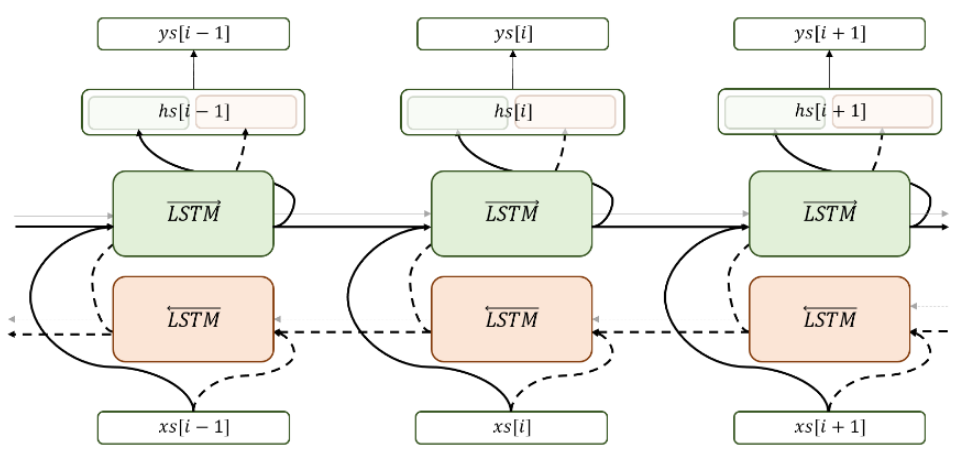

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# 학습시 padding처리된 경우 test에서도 padding 처리해야함
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

## 2개 이상 LSTM layers


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

In [ ]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

In [ ]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

In [ ]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')